In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import re
import time
from BusinessHours import BusinessHours as bh
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Imputer
from sklearn.metrics import make_scorer 
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn import metrics
from sklearn.pipeline import Pipeline

In [90]:
df = pd.read_csv('train_aWnotuB.csv', parse_dates=['DateTime'], index_col='DateTime', infer_datetime_format=True)
df_test = pd.read_csv('test_BdBKkAj.csv', parse_dates=['DateTime'], index_col='DateTime', infer_datetime_format=True)

In [5]:
df.head()
#df.describe()

,Junction,Vehicles,ID
DateTime,,,
2015-11-01 00:00:00,1,15,20151101001
2015-11-01 01:00:00,1,13,20151101011
2015-11-01 02:00:00,1,10,20151101021
2015-11-01 03:00:00,1,7,20151101031
2015-11-01 04:00:00,1,9,20151101041


In [199]:
#df = df_train[df.columns.difference(['ID'])]

In [91]:
def add_date_features(df):
    #df['date'] = pd.to_datetime(df['DateTime'])
    dti = df.index #pd.DatetimeIndex(df['date'])
    df['DateTime'] = dti
    holidays = calendar().holidays(start=dti.min(), end=dti.max())

    df['year'] = dti.year
    df['quarter'] = dti.quarter
    df['month'] = dti.month
    df['week'] = dti.week
    df['weekofyear'] = dti.weekofyear
    df['day'] = dti.day
    df['dayofweek'] = dti.dayofweek
    df['dayofyear'] = dti.dayofyear
    df['hour'] = dti.hour
    df['minofday'] = dti.hour*60+dti.minute
    df['bhour'] = df['hour']
    df['bhour'] = df['bhour'].replace(range(1,8), 0).replace(range(8,19), 1).replace(range(19,24), 0)
    df['holiday'] = dti.isin(holidays)
    df['holiday'] = df['holiday'].map({False:0, True:1})
    
add_date_features(df)
add_date_features(df_test)

# df['year'], df['month'], df['week'], df['day'], df['dayofweek'], df['hour'], df['minofday'] = \
# df['date'].dt.year, df['date'].dt.month, df['date'].dt.week, df['date'].dt.day, df['date'].dt.dayofweek, df['date'].dt.hour, df['date'].dt.hour*60+df['date'].dt.minute

In [10]:
#df.date = df.DateTime.apply(lambda x: time.mktime(pd.Timestamp(x).to_datetime().timetuple()))
#df.index.year

In [202]:
# from tsfresh import extract_relevant_features
# extracted_features = extract_relevant_features(df, df.Vehicles, column_sort="DateTime", column_id="Junction", column_value="Vehicles", n_jobs=4)

In [203]:
#vehicles

In [204]:
# #temps = DataFrame(df.Vehicles)
# # dataframe = concat([temps.shift(1), temps], axis=1)
# # dataframe.columns = ['t-1', 't+1']
# def lag(df):
#     vehicles = df.Vehicles
#     dataframe = pd.concat([vehicles.shift(3), vehicles.shift(2), vehicles.shift(1), vehicles], axis=1)
#     dataframe.columns = ['t-3', 't-2', 't-1', 't+1']
#     print(dataframe.head(5))
# vehicles = df.groupby('Junction').apply(lag)

In [205]:
def window_features(df):
    width = 3
    v = df.Vehicles
    shifted = v.shift(width - 1)
    window = shifted.rolling(window=width)
    exp = v.expanding()
    dataframe = pd.concat([window.min(), window.mean(), window.max(), exp.min(), exp.mean(), exp.max(), v], axis=1)
    dataframe.columns = ['s_min', 's_mean', 's_max', 'e_min', 'e_mean', 'e_max', 's_t+1']
    #print(dataframe.head(5))
    return dataframe
#window(df)

def merge_features(df, vehicles):
    df['s_min'] = vehicles['s_min']
    df['s_mean'] = vehicles['s_mean']
    df['s_max'] = vehicles['s_max']
    df['e_min'] = vehicles['e_min']
    df['e_mean'] = vehicles['e_mean']
    df['e_max'] = vehicles['e_max']

#merge_features(df, df.groupby('Junction').apply(window_features))
#merge_features(df_test, df_test.groupby('Junction').apply(window_features))

#vehicles.head()

In [114]:
#df['Junction'].unique()
df.reset_index(inplace=True)
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'year', 'quarter', 'month', 'week',
       'weekofyear', 'day', 'dayofweek', 'dayofyear', 'hour', 'minofday',
       'bhour', 'holiday',
       '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5',
       '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2',
       '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20',
       '2__fft_coefficient__coeff_0__attr_"abs"',
       '2__fft_coefficient__coeff_0__attr_"real"', '2__maximum', '2__mean',
       '2__median', '2__minimum', '2__quantile__q_0.1', '2__quantile__q_0.2',
       '2__quantile__q_0.3', '2__quantile__q_0.4', '2__quantile__q_0.6',
       '2__quantile__q_0.7', '2__quantile__q_0.8', '2__quantile__q_0.9',
       '2__sum_values',
       '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10',
       '2__abs_energy', '1__abs_energy', '1__quantile__q_0.9',
       '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10',
       '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_

In [30]:
from tsfresh import extract_relevant_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import make_forecasting_frame

#df_shift, y = make_forecasting_frame(df['Vehicles'], kind="Junction", max_timeshift=10, rolling_direction=1)
df = extract_relevant_features(df, df.Vehicles.values, column_sort="DateTime", column_id="ID", column_kind="Junction", column_value="Vehicles")

# pipeline = Pipeline([('augmenter', RelevantFeatureAugmenter(column_id='ID', column_sort='DateTime', column_kind="Junction", column_value="Vehicles"))])
# pipeline.set_params(augmenter__timeseries_container=df)
# pipeline.fit(df, df.Vehicles)

Feature Extraction: 100%|██████████| 10/10 [26:17<00:00, 157.79s/it]
 '1__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 '1__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"' ...,
 '4__spkt_welch_density__coeff_2' '4__spkt_welch_density__coeff_5'
 '4__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [32]:
#df_ext = df

In [92]:
for feature in df_ext.columns:
    df[feature.replace(" ", "")] = df_ext[feature].values

In [96]:
# df['2__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5'] = df_ext['2__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5']
# df_ext.shape
# df.shape
#df_ext[0]
#df['2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5']

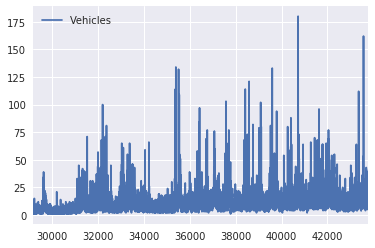

In [208]:
df[df['Junction']==3][['date', 'Vehicles']].plot()

(array([  1.13190000e+04,   2.87900000e+03,   2.79000000e+02,
          6.30000000e+01,   2.60000000e+01,   1.10000000e+01,
          9.00000000e+00,   3.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   18.9,   36.8,   54.7,   72.6,   90.5,  108.4,  126.3,
         144.2,  162.1,  180. ]),
 <a list of 10 Patch objects>)

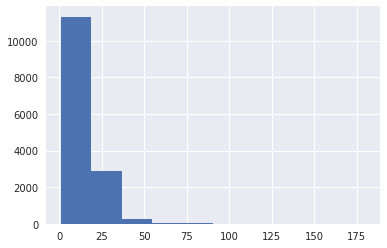

In [209]:
plt.hist(df[df['Junction']==3]['Vehicles'])

In [210]:
# corrmat = df.corr()
# f, ax = plt.subplots(figsize=(12, 9))
# sns.heatmap(corrmat, vmax=.8, square=True);

In [211]:

# sns.set()
# sns.pairplot(df)
# plt.show();

In [97]:
X_test_Id = df_test[['ID']]
df.drop(['ID', 'DateTime'], inplace=True, axis=1)
df_test.drop(['ID', 'DateTime'], inplace=True, axis=1)
train, val = np.split(df.sample(frac=1), [int(.99*len(df))])
X_train = train.drop('Vehicles', axis=1)
y_train = train.Vehicles.values
X_val = val.drop('Vehicles', axis=1)
y_val = val.Vehicles.values
X_test = df_test
num_cols = list(X_train.columns.get_values())
num_cols.remove('Junction')
cat_cols = ['Junction']

### Check missing values

In [99]:
pd.isnull(X_train).sum()
#X_train.shape
#X_train

Junction                                                  0
year                                                      0
quarter                                                   0
month                                                     0
week                                                      0
weekofyear                                                0
day                                                       0
dayofweek                                                 0
dayofyear                                                 0
hour                                                      0
minofday                                                  0
bhour                                                     0
holiday                                                   0
2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5     0
2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2     0
2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20    0
2__fft_coefficient__coeff_0__attr_"abs" 

In [100]:
from collections import defaultdict
d = defaultdict(list)
X_train[cat_cols].apply(lambda x: d[x.name].append(x.value_counts().idxmax())) 
ohe = OneHotEncoder().fit(X_train[cat_cols])
#cols = [cat_cols[i] + '=' + str(d[cat_cols[i]].classes_[j]) for i in range(0,len(cat_cols)) for j in range(0,ohe.n_values_[i])]
cols = [cat_cols[i] + '=' + str(j) for i in range(0,len(cat_cols)) for j in range(1,ohe.n_values_[i])]

X_train_cat = pd.DataFrame(ohe.transform(X_train[cat_cols]).toarray(), columns=cols)
X_val_cat = pd.DataFrame(ohe.transform(X_val[cat_cols]).toarray(), columns=cols)
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]).toarray(), columns=cols)

# from sklearn.feature_extraction import DictVectorizer
# vec = DictVectorizer().fit(X_train[cat_cols].to_dict('records'))
# X_train_cat = pd.DataFrame(vec.transform(X_train[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_val_cat = pd.DataFrame(vec.transform(X_val[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())
# X_test_cat = pd.DataFrame(vec.transform(X_test[cat_cols].to_dict('records')).toarray(), columns=vec.get_feature_names())

In [102]:
imp_num = Imputer(missing_values='NaN', strategy='mean', axis=0).fit(X_train[num_cols])
X_train[num_cols] = imp_num.transform(X_train[num_cols])
X_val[num_cols] = imp_num.transform(X_val[num_cols])
#X_test[num_cols] = imp_num.transform(X_test[num_cols])

In [104]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train[num_cols])
X_train_num = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
X_val_num = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
#X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

In [105]:
X_train = X_train_num.join(X_train_cat)
X_val = X_val_num.join(X_val_cat)
#X_test = X_test_num.join(X_test_cat)

In [106]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)

In [111]:
#model = KernelRidge(alpha=1.0).fit(X_train, y_train)
model = XGBRegressor().fit(X_train, y_train)

In [110]:
#model = XGBRegressor().fit(X_train, y_train)
#model = XGBRegressor()
#ada = AdaBoostRegressor()

# y_pred = [0] * len(y_train)
# y_pred[0] = y_train[0]

# for i in range(1, len(y)):
#     model.fit(X_train[:i], y[:i])
#     y_pred[i] = model.predict(X_train[:i])
    
# y_pred = pd.Series(data=y_pred, index=y.index)

In [112]:
y_pred = model.predict(X_val)
metrics.mean_squared_error(y_val, y_pred)

32.152735520074053

In [113]:
#y_pred = model.predict(X_test).round().astype('int')
X_test_Id['Vehicles'] = model.predict(X_test).round().astype('int')

ValueError: feature_names mismatch: ['year', 'quarter', 'month', 'week', 'weekofyear', 'day', 'dayofweek', 'dayofyear', 'hour', 'minofday', 'bhour', 'holiday', '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5', '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2', '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20', '2__fft_coefficient__coeff_0__attr_"abs"', '2__fft_coefficient__coeff_0__attr_"real"', '2__maximum', '2__mean', '2__median', '2__minimum', '2__quantile__q_0.1', '2__quantile__q_0.2', '2__quantile__q_0.3', '2__quantile__q_0.4', '2__quantile__q_0.6', '2__quantile__q_0.7', '2__quantile__q_0.8', '2__quantile__q_0.9', '2__sum_values', '2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10', '2__abs_energy', '1__abs_energy', '1__quantile__q_0.9', '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10', '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2', '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20', '1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5', '1__sum_values', '1__fft_coefficient__coeff_0__attr_"real"', '1__maximum', '1__mean', '1__median', '1__fft_coefficient__coeff_0__attr_"abs"', '1__quantile__q_0.1', '1__quantile__q_0.2', '1__quantile__q_0.3', '1__quantile__q_0.4', '1__quantile__q_0.6', '1__quantile__q_0.7', '1__quantile__q_0.8', '1__minimum', '3__quantile__q_0.2', '3__quantile__q_0.3', '3__quantile__q_0.4', '3__quantile__q_0.6', '3__sum_values', '3__quantile__q_0.8', '3__quantile__q_0.9', '3__quantile__q_0.1', '3__quantile__q_0.7', '3__minimum', '3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10', '3__mean', '3__maximum', '3__fft_coefficient__coeff_0__attr_"real"', '3__fft_coefficient__coeff_0__attr_"abs"', '3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5', '3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20', '3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2', '3__median', '3__abs_energy', '3__value_count__value_1', '4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10', '4__sum_values', '4__quantile__q_0.9', '4__quantile__q_0.8', '4__quantile__q_0.7', '4__quantile__q_0.6', '4__quantile__q_0.4', '4__quantile__q_0.3', '4__quantile__q_0.2', '4__quantile__q_0.1', '4__minimum', '4__median', '4__mean', '4__maximum', '4__fft_coefficient__coeff_0__attr_"abs"', '4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5', '4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20', '4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2', '4__abs_energy', '4__fft_coefficient__coeff_0__attr_"real"', 'Junction=1', 'Junction=2', 'Junction=3', 'Junction=4'] ['Junction', 'year', 'quarter', 'month', 'week', 'weekofyear', 'day', 'dayofweek', 'dayofyear', 'hour', 'minofday', 'bhour', 'holiday']
expected 1__quantile__q_0.8, 1__median, 2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20, 3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5, 4__abs_energy, 2__minimum, 3__maximum, 4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20, 1__quantile__q_0.6, 4__quantile__q_0.3, 1__minimum, 3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10, 1__quantile__q_0.1, 2__quantile__q_0.9, 1__quantile__q_0.3, 1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5, 4__quantile__q_0.6, 1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20, 1__fft_coefficient__coeff_0__attr_"abs", 2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2, 2__sum_values, 1__quantile__q_0.4, 1__maximum, 4__fft_coefficient__coeff_0__attr_"abs", 4__quantile__q_0.1, 4__fft_coefficient__coeff_0__attr_"real", 4__median, 3__fft_coefficient__coeff_0__attr_"abs", 1__abs_energy, 3__quantile__q_0.7, 4__quantile__q_0.8, 4__quantile__q_0.4, 1__quantile__q_0.2, Junction=1, 1__quantile__q_0.7, 2__quantile__q_0.3, 3__quantile__q_0.9, 3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2, 4__maximum, 2__quantile__q_0.7, 3__median, 3__quantile__q_0.4, 3__quantile__q_0.6, 2__maximum, 3__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_20, 4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2, 2__mean, 4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5, 1__quantile__q_0.9, 1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10, 2__quantile__q_0.6, 2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_5, 3__value_count__value_1, 1__fft_coefficient__coeff_0__attr_"real", 2__fft_coefficient__coeff_0__attr_"abs", 3__minimum, 3__quantile__q_0.1, 3__quantile__q_0.3, 4__quantile__q_0.9, 3__sum_values, 4__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10, 3__quantile__q_0.2, 2__quantile__q_0.2, 4__quantile__q_0.2, 3__abs_energy, 1__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_2, 4__minimum, 2__quantile__q_0.1, 2__fft_coefficient__coeff_0__attr_"real", 2__quantile__q_0.4, 1__mean, 4__quantile__q_0.7, 2__quantile__q_0.8, 3__mean, 2__abs_energy, Junction=4, Junction=3, 1__sum_values, 2__cwt_coefficients__widths_(2,5,10,20)__coeff_0__w_10, 3__fft_coefficient__coeff_0__attr_"real", Junction=2, 4__mean, 2__median, 3__quantile__q_0.8, 4__sum_values in input data
training data did not have the following fields: Junction

In [238]:
X_test_Id.to_csv('xgb_result.csv', index=False)